In [30]:
import numpy as np # linear algebra
import pandas as pd

In [31]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!nvidia-smi 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [35]:
!pip install textblob


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [37]:
data = pd.read_csv('preprocess_dataset.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652 entries, 0 to 2651
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2652 non-null   int64 
 1   heading     2652 non-null   object
 2   text        2645 non-null   object
 3   url         2652 non-null   object
dtypes: int64(1), object(3)
memory usage: 83.0+ KB


In [38]:
data.shape

(2652, 4)

In [39]:
data.head()

,Unnamed: 0,heading,text,url
0,0,Reasons to Buy Bajaj Allianz Travel Insurance,Whether you are planning a solo backpacking tr...,https://www.bajajfinservmarkets.in/insurance/t...
1,1,Why Travel Insurance is a Must-Have?,Why Travel Insurance is a Must-Have?What is th...,https://www.bajajfinservmarkets.in/insurance/t...
2,2,Why Choose Bajaj Allianz Travel Insurance?,Why Choose Bajaj Allianz Travel Insurance?You ...,https://www.bajajfinservmarkets.in/insurance/t...
3,3,Types of Travel Insurance Plans Available on F...,Types of Travel Insurance Plans Available on F...,https://www.bajajfinservmarkets.in/insurance/t...
4,4,Top Destination Covered Under Travel Insurance...,Top Destination Covered Under Travel Insurance...,https://www.bajajfinservmarkets.in/insurance/t...


In [40]:
import gc
df = data[['heading','text','url']]
del data
gc.collect()

5944

In [41]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['heading'],inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


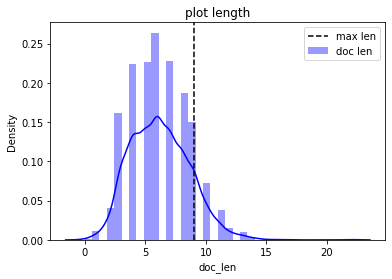

In [42]:
df['doc_len'] = df['heading'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [43]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import faiss
encoded_data = model.encode(df.heading.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index1=faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'heading.index')
faiss.write_index(index1,'url.index')

In [ ]:
df.head()

In [58]:
def fetch_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['heading'] = info['heading']
    meta_dict['url']=info['url']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_info(idx) for idx in top_k_ids]
    return results

In [59]:
from pprint import pprint

query="Health Insurance"
results=search(query, top_k=5, index=index, model=model)

for r in results:
    print(r)

>>>> Results in Total Time: 0.07912921905517578
{'heading': 'What is Health Insurance?', 'url': 'https://www.bajajfinservmarkets.in/insurance/health-insurance.html'}
{'heading': 'Health Insurance in India', 'url': 'https://www.bajajfinservmarkets.in/insurance/health-insurance/important-features-of-health-insurance.html'}
{'heading': 'What Is Health Insurance?', 'url': 'https://www.bajajfinservmarkets.in/insurance/health-insurance/health-insurance-vs-critical-illness.html'}
{'heading': 'Health Insurance App', 'url': 'https://www.bajajfinservmarkets.in/insurance/health-insurance/health-insurance-app.html'}
{'heading': '1. Health Insurance', 'url': 'https://www.bajajfinservmarkets.in/insurance/types-of-insurance.html'}
